# 4995 005 Homework 3 
#### Team: Lehui Liu (ll3238), Yinheng Li (yl4039)

## Background
We have the dataset from https://www.cms.gov/OpenPayments/Explore-the-Data/Dataset-Downloads.html, our goal is to predict whether a payment by a company to a medical doctor or facility was made as part of a research project or not.

## Task 1 Identify Features

Since the dataset downloaded is extremely large and hard to fit into memory.  
I use the below sample command for dataframe from pandas to subsample two small datafile which is 10% of their original file.  
First I use the general payments as class 0 and research payments as class 1.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# I use the blow code to subsample data.
# generals = pd.read_csv("../PGYR17_P011819/OP_DTL_GNRL_PGYR2017_P01182019.csv")
# subset_generals = generals.sample(frac = 0.1,random_state = 4995)
# subset_generals.to_csv('subset_generals.csv')
# researches = pd.read_csv("../PGYR17_P011819/OP_DTL_RSRCH_PGYR2017_P01182019.csv")
# subset_researches = researches.sample(frac = 0.1,random_state = 4995)
# subset_researches.to_csv('subset_researches.csv')
generals = pd.read_csv('subset_generals.csv')
researches = pd.read_csv('subset_researches.csv')

Again, we sample 3% of the subsets for this task.

In [3]:
generals = generals.sample(frac = 0.03,random_state = 4995)
researches = researches.sample(frac = 0.03, random_state = 4995)
print(generals.shape)
print(researches.shape)


(31991, 76)
(1808, 177)


In [4]:
generals.set_index('Unnamed: 0',inplace = True)
researches.set_index('Unnamed: 0',inplace = True)
generals.index.names = ['index']
researches.index.names = ['index']

### target leakage

First, we select the common columns (i.e. features) in both researches and generals payment dataset in case of target leakage.

In [5]:
features_generals = set(generals.columns)
features_researches = set(researches.columns)
features = list(features_generals.intersection(features_researches))
len(features)

64

In [6]:
generals = generals[features]
researches = researches[features]

In [7]:
generals['target'] = 0
researches['target'] = 1
data = pd.concat([generals,researches],ignore_index = True)
print(data.shape)
data.head()

(33799, 65)


,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1,Physician_Primary_Type,Teaching_Hospital_Name,Covered_or_Noncovered_Indicator_4,Product_Category_or_Therapeutic_Area_1,Associated_Drug_or_Biological_NDC_4,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2,Recipient_Province,Product_Category_or_Therapeutic_Area_3,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID,...,Physician_Middle_Name,Recipient_State,Delay_in_Publication_Indicator,Covered_or_Noncovered_Indicator_3,Physician_License_State_code5,Covered_or_Noncovered_Indicator_1,Associated_Drug_or_Biological_NDC_3,Record_ID,Physician_Last_Name,target
0,FARXIGA,Medical Doctor,NaN,NaN,Cardiovascular and Metabolism,NaN,NaN,NaN,NaN,100000000146,...,L,SC,No,NaN,NaN,Covered,NaN,444903407,Culleton,0
1,BEVESPI AEROSPHERE,Medical Doctor,NaN,NaN,Respiratory,NaN,NaN,NaN,NaN,100000000146,...,A,NY,No,NaN,NaN,Covered,NaN,445968994,Aziz,0
2,Viekira,Medical Doctor,NaN,NaN,Virology,NaN,NaN,NaN,NaN,100000000204,...,NaN,TX,No,NaN,NaN,Covered,NaN,472013519,GILLMAN,0
3,LYRICA,Medical Doctor,NaN,NaN,NEUROSCIENCE;PAIN,NaN,VIAGRA,NaN,NaN,100000000286,...,E,CA,No,NaN,NaN,Covered,NaN,503073935,DAGLISH,0
4,NaN,Medical Doctor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100000005432,...,S,OH,No,NaN,NaN,NaN,NaN,440031813,MARCU,0


### EDA

#### 1. target distribution
From the following figure, we can see this is an imbalanced dataset.

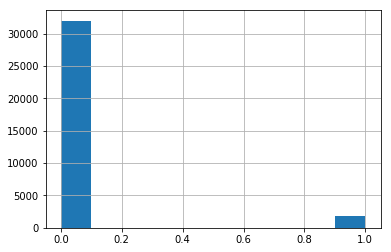

In [8]:
data['target'].hist()

#### 2. missing pattern
We plot the missing pattern in the dataset and drop the feature who has over 80% missing data.

(33799, 36)


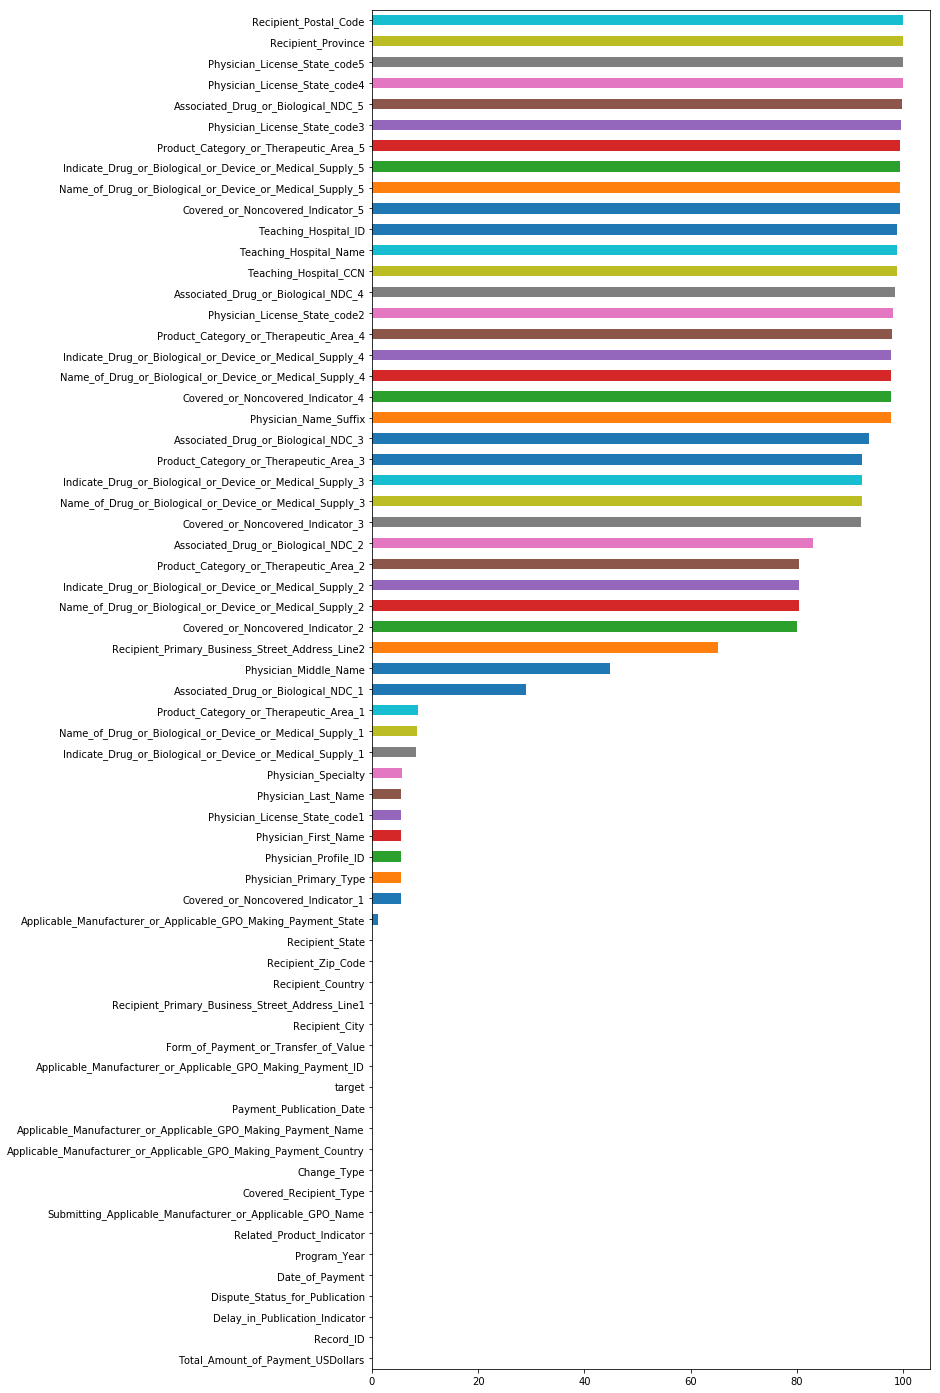

In [9]:
missing_percent = data.isna().sum() / len(data) * 100
missing_percent.sort_values().plot('barh',figsize = (10,25))
missing_col = list(missing_percent[missing_percent > 80].index)
data.drop(missing_col,axis = 1,inplace = True)
print(data.shape)

We notice that some columns are strongly correlated. For example, Teaching_Hospital_CCN,Teaching_Hostpital_ID are basically redundant since we already have Teaching_Hostipital_Name.  
Second, we do not need record ID since it is just a identifier.  
Besides, since we already include the Physician_Profile_Id, we think it is unnecessary to include Name feature related to physician any more.  
What's more, we include zip code and country in the features, we do not need the address information anymore.

In [10]:
data.columns

Index(['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Physician_Primary_Type', 'Product_Category_or_Therapeutic_Area_1',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
       'Form_of_Payment_or_Transfer_of_Value',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Physician_Specialty', 'Payment_Publication_Date',
       'Physician_Profile_ID', 'Physician_License_State_code1',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
       'Recipient_Country', 'Recipient_City',
       'Recipient_Primary_Business_Street_Address_Line1',
       'Total_Amount_of_Payment_USDollars',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Change_Type', 'Covered_Recipient_Type',
       'Associated_Drug_or_Biological_NDC_1',
       'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
       'Recipient_Zip

In [11]:
to_drop = ['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID', \
           'Recipient_Primary_Business_Street_Address_Line1', \
           'Recipient_Primary_Business_Street_Address_Line2',\
           'Physician_Middle_Name','Physician_First_Name','Physician_Last_Name', \
           'Record_ID']
data.drop(to_drop, axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33799 entries, 0 to 33798
Data columns (total 29 columns):
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1            30945 non-null object
Physician_Primary_Type                                              31913 non-null object
Product_Category_or_Therapeutic_Area_1                              30861 non-null object
Form_of_Payment_or_Transfer_of_Value                                33799 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1           31015 non-null object
Physician_Specialty                                                 31880 non-null object
Payment_Publication_Date                                            33799 non-null object
Physician_Profile_ID                                                31913 non-null float64
Physician_License_State_code1                                       31913 non-null object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name       33799 non-nu

In [12]:
print(data.dtypes[data.dtypes == float])
print(data.dtypes[data.dtypes == int])

Physician_Profile_ID                 float64
Total_Amount_of_Payment_USDollars    float64
dtype: object
Program_Year    int64
target          int64
dtype: object


we change the physician_profile_id and applicable_manufacturer_or_applicable_gpo_making_payment_id and program_year to categorical.

In [13]:
to_cat = ['Physician_Profile_ID','Program_Year']
data.loc[:,to_cat] = data.loc[:,to_cat].astype(object)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33799 entries, 0 to 33798
Data columns (total 29 columns):
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1            30945 non-null object
Physician_Primary_Type                                              31913 non-null object
Product_Category_or_Therapeutic_Area_1                              30861 non-null object
Form_of_Payment_or_Transfer_of_Value                                33799 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1           31015 non-null object
Physician_Specialty                                                 31880 non-null object
Payment_Publication_Date                                            33799 non-null object
Physician_Profile_ID                                                31913 non-null object
Physician_License_State_code1                                       31913 non-null object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name       33799 non-nul

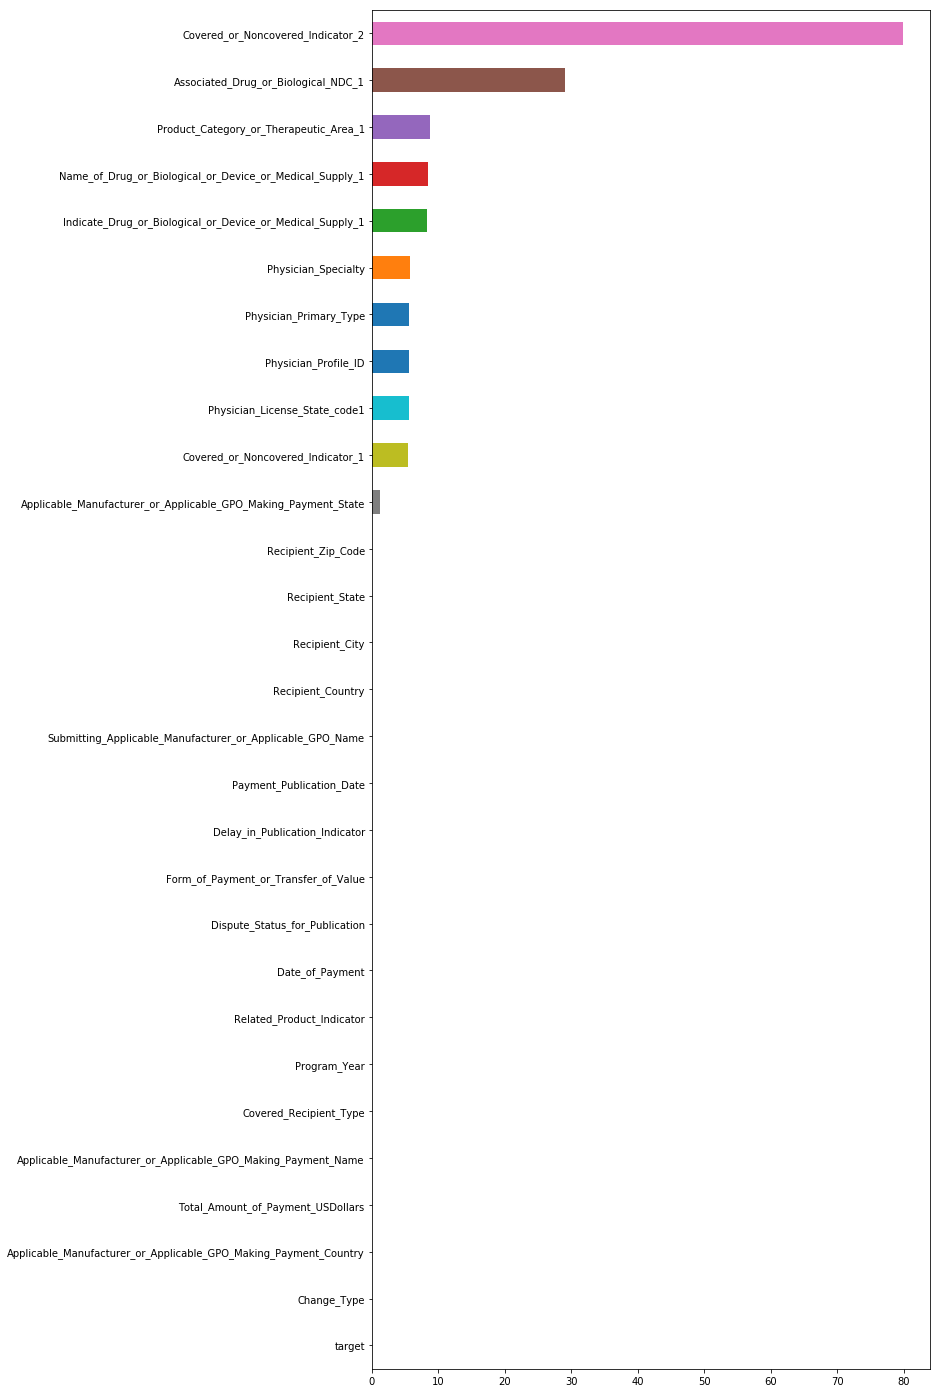

In [14]:
missing_percent = data.isnull().sum() / len(data) * 100
missing_percent.sort_values().plot('barh',figsize = (10,25))

### Conclusion
For now, we only discard some features with missing data and intersection. They are not our final features. As we develop the model, we continuous focus on the features. We double check for target leakage in the following section.

## Task 2 Preprocessing and Baseline Model

#### Missing data

In [15]:
data_task2 = data.copy()

In [16]:
y = data_task2['target']
X = data_task2.drop(['target'],axis = 1)
X.shape

(33799, 28)

In [17]:
continous_features = ['Total_Amount_of_Payment_USDollars']
categorical_features = list(set(X.columns) - set(continous_features))
print(len(categorical_features))

27


In [18]:
X.shape

(33799, 28)

#### impute missing data

In [19]:
X_task2 = X.replace(to_replace={var:np.NaN for var in categorical_features},value="N/A")

In [20]:
print(X_task2.shape)
print(y.shape)

(33799, 28)
(33799,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_task2,y,test_size=0.2,random_state=4995)

In [22]:
print(y_train.shape)
print(X_train.shape)

(27039,)
(27039, 28)


In [23]:
preprocess = make_column_transformer(
    (StandardScaler(), continous_features),remainder='passthrough')
X_train_scaled = preprocess.fit_transform(X_train)
print(X_train_scaled.shape)

(27039, 28)


In [24]:
X_test_scaled = preprocess.transform(X_test)
print(X_test_scaled.shape)

(6760, 28)


#### In the baseline method, we target encoding all the categorical features because some categorical data has too many unique values.

In [25]:
encoder = ce.TargetEncoder()
encoder.fit(X_train_scaled, y_train)
X_train_scaled_cleaned = encoder.transform(X_train_scaled)
X_test_scaled_cleaned = encoder.transform(X_test_scaled)
print(X_train_scaled_cleaned.shape)
print(X_test_scaled_cleaned.shape)

(27039, 28)
(6760, 28)


#### double check whether there is data leakage

In [26]:
for col in X_train_scaled_cleaned.columns:
    coef = np.corrcoef(X_train_scaled_cleaned[col],y_train)
    print(col)
    print(coef)

0
[[1.         0.09130367]
 [0.09130367 1.        ]]
1
[[1.         0.03770467]
 [0.03770467 1.        ]]
2
[[ 1.         -0.00431032]
 [-0.00431032  1.        ]]
3
[[ 1.         -0.00781095]
 [-0.00781095  1.        ]]
4
[[nan nan]
 [nan  1.]]
5
[[ 1.         -0.00609673]
 [-0.00609673  1.        ]]
6
[[ 1.        -0.0134344]
 [-0.0134344  1.       ]]
7
[[nan nan]
 [nan  1.]]
8
[[ 1.         -0.60609434]
 [-0.60609434  1.        ]]
9
[[ 1.        -0.0030161]
 [-0.0030161  1.       ]]
10
[[1.        0.0124483]
 [0.0124483 1.       ]]
11
[[ 1.         -0.00143656]
 [-0.00143656  1.        ]]
12
[[ 1.         -0.03274023]
 [-0.03274023  1.        ]]
13
[[ 1.         -0.00197304]
 [-0.00197304  1.        ]]
14
[[ 1.         -0.00292269]
 [-0.00292269  1.        ]]
15
[[nan nan]
 [nan  1.]]
16
[[nan nan]
 [nan  1.]]
17
[[1.         0.07773414]
 [0.07773414 1.        ]]
18
[[ 1.00000000e+00 -4.14039021e-04]
 [-4.14039021e-04  1.00000000e+00]]
19
[[ 1.        -0.1200138]
 [-0.1200138  1.    

In [27]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import cross_validate
undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegression())
scores = cross_validate(undersample_pipe,
                        X_train_scaled_cleaned, y_train, cv=5,
                        scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9789755915662737, 0.6740254086361378)

### Conclusion
We developed a baseline model using Logistic Regression with UnderSampler from imblearn.    
This is because we have an imbalanced dataset.   
And we choose roc_auc and average_precision as our metric.  
The result is auc = 0.978, average_precision = 0.664.  

## Task 3 Feature Engineering

In [28]:
X_task3 = X_task2.copy()

In [29]:
X_task3.head()

,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1,Physician_Primary_Type,Product_Category_or_Therapeutic_Area_1,Form_of_Payment_or_Transfer_of_Value,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1,Physician_Specialty,Payment_Publication_Date,Physician_Profile_ID,Physician_License_State_code1,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,...,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name,Recipient_Zip_Code,Covered_or_Noncovered_Indicator_2,Related_Product_Indicator,Program_Year,Date_of_Payment,Dispute_Status_for_Publication,Recipient_State,Delay_in_Publication_Indicator,Covered_or_Noncovered_Indicator_1
0,FARXIGA,Medical Doctor,Cardiovascular and Metabolism,In-kind items and services,Drug,Allopathic & Osteopathic Physicians|Internal M...,01/18/2019,345267,SC,AstraZeneca Pharmaceuticals LP,...,AstraZeneca Pharmaceuticals LP,29505-6046,N/A,Yes,2017,02/13/2017,No,SC,No,Covered
1,BEVESPI AEROSPHERE,Medical Doctor,Respiratory,In-kind items and services,Drug,Allopathic & Osteopathic Physicians|Internal M...,01/18/2019,295180,NY,AstraZeneca Pharmaceuticals LP,...,AstraZeneca Pharmaceuticals LP,13204-3127,N/A,Yes,2017,11/01/2017,No,NY,No,Covered
2,Viekira,Medical Doctor,Virology,In-kind items and services,Drug,Allopathic & Osteopathic Physicians|Internal M...,01/18/2019,19128,TX,"AbbVie, Inc.",...,"AbbVie, Inc.",75208-4531,N/A,Yes,2017,04/27/2017,No,TX,No,Covered
3,LYRICA,Medical Doctor,NEUROSCIENCE;PAIN,In-kind items and services,Drug,Allopathic & Osteopathic Physicians|General Pr...,01/18/2019,181197,CA,PFIZER INC.,...,Pfizer Inc.,93277,Covered,Yes,2017,03/07/2017,No,CA,No,Covered
4,N/A,Medical Doctor,N/A,Cash or cash equivalent,N/A,Allopathic & Osteopathic Physicians|Internal M...,01/18/2019,1.0071e+06,OH,Purdue Pharma L.P.,...,Purdue Pharma L.P.,44113-3108,N/A,No,2017,04/24/2017,No,OH,No,N/A


### log transformation on continuous data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3eeacfd0>]],
      dtype=object)

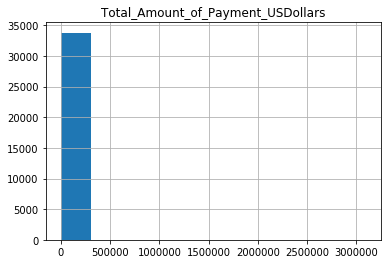

In [30]:
X_task3[['Total_Amount_of_Payment_USDollars']].hist()

we can see that the only numerical variable is also very right skewed. Thus, we use a log transformation.

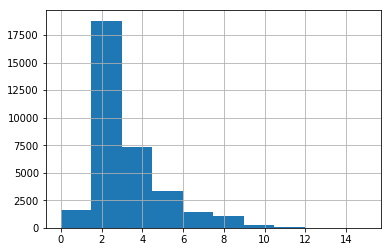

In [31]:
X_task3['Total_Amount_of_Payment_USDollars'] = np.log(X_task3['Total_Amount_of_Payment_USDollars'] + 1)
X_task3['Total_Amount_of_Payment_USDollars'].hist()

### one-hot encoding and target encoding on categorical data

In [32]:
one_hot_categorical = []
target_categorical = []
for col in categorical_features:
    if len(X_task3[col].unique()) < 10:
        one_hot_categorical.append(col)
    else:
        target_categorical.append(col)
assert len(one_hot_categorical) + len(target_categorical) == len(categorical_features)
print(len(one_hot_categorical))
print(len(target_categorical))

13
14


In [33]:
X_train_3,X_test_3,y_train_3,y_test_3 = train_test_split(X_task3,y,test_size=0.2,random_state=4995)

In [34]:
X_train_3.head()
X_train_3 = X_train_3.reset_index()
y_train_3 = y_train_3.reset_index()
X_test_3 = X_test_3.reset_index()
y_test_3 = y_test_3.reset_index()
X_train_3.drop(['index'],axis = 1,inplace = True)
X_test_3.drop(['index'],axis = 1,inplace = True)
y_train_3.drop(['index'],axis = 1,inplace = True)
y_test_3.drop(['index'],axis = 1,inplace = True)

In [35]:
encoder = ce.TargetEncoder(handle_unknown='ignore')
# encoder.fit_transform(X_train_3, y_train_3)
# X_train_scaled_cleaned = encoder.transform(X_train_scaled)
# X_test_3= encoder.transform(X_test_3)
# print(X_train_3.shape)
# print(X_test_3.shape)
# print(X_train_3.head())

In [36]:
preprocess = make_column_transformer(
    (StandardScaler(), continous_features),\
    (OneHotEncoder(),one_hot_categorical), \
    (encoder,target_categorical),\
    remainder='passthrough')
X_train_3 = preprocess.fit_transform(X_train_3,y_train_3)
print(X_train_3.shape)

(27039, 50)


In [37]:
undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegression())
scores = cross_validate(undersample_pipe,
                        X_train_3, y_train_3, cv=5,
                        scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9992313699576487, 0.9910813094310829)

### Conclusion
  
In this task 3, we did some feature engineering work.    
We make the continuous variable more normal than before using **log transformaion**.  
We compute the unique value in each categorical features.   
Then, we apply **one hot encoding** the features has less than 10 unique values.   
Also we apply **target encoding** the one with over 10 unique values.    
As we can see from cross validation result, the test_roc_auc and average_precision score both increase.
especially for the average_precision score from 0.664 -> 0.989

## Task 4 Any model

### SVM

#### ROC_AUC

In [38]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LinearSVC())
param_grid_svm = {'linearsvc__C': np.logspace(-3, 2, 6)}
grid_svm = GridSearchCV(undersample_pipe,param_grid_svm,scoring='roc_auc',cv=5)

In [39]:
grid_svm.fit(X_train_3,y_train_3)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('randomundersampler', RandomUnderSampler(random_state=None, ratio=None, replacement=False,
          return_indices=False, sampling_strategy='auto')), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'linearsvc__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [40]:
result_svm = pd.DataFrame(grid_svm.cv_results_)

In [41]:
result_svm.head(n=6)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_linearsvc__C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.019608,0.004207,0.998137,0.998168,0.001,{'linearsvc__C': 0.001},6,0.998698,0.998088,0.998639,...,0.998659,0.998043,0.997898,0.998245,0.996790,0.998512,0.005321,0.001025,0.000736,0.000196
1,0.013103,0.003235,0.999024,0.999058,0.01,{'linearsvc__C': 0.01},4,0.999501,0.998898,0.999147,...,0.999321,0.999098,0.998971,0.999126,0.998182,0.999342,0.000284,0.000185,0.000457,0.000183
2,0.014193,0.003122,0.999150,0.999455,0.1,{'linearsvc__C': 0.1},3,0.999761,0.999464,0.999616,...,0.999439,0.999396,0.999243,0.999381,0.997693,0.999565,0.000461,0.000082,0.000749,0.000065
3,0.024241,0.003109,0.999360,0.999579,1,{'linearsvc__C': 1.0},1,0.999767,0.999534,0.999716,...,0.999568,0.999501,0.999423,0.999571,0.998324,0.999772,0.002706,0.000137,0.000532,0.000100
4,0.029471,0.003146,0.999256,0.999555,10,{'linearsvc__C': 10.0},2,0.999536,0.999472,0.999812,...,0.999803,0.999507,0.999199,0.999616,0.997931,0.999721,0.002320,0.000116,0.000699,0.000099
5,0.026932,0.003089,0.998954,0.999401,100,{'linearsvc__C': 100.0},5,0.999114,0.999293,0.999648,...,0.999660,0.999426,0.998577,0.999401,0.997772,0.999619,0.002366,0.000034,0.000713,0.000125


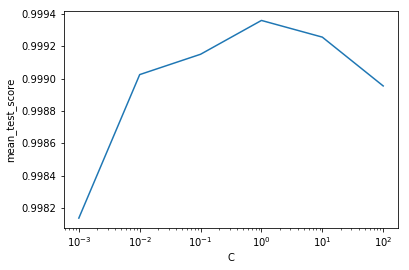

In [42]:
plt.plot(result_svm['param_linearsvc__C'],result_svm['mean_test_score'])
plt.xlabel('C')
plt.ylabel('mean_test_score')
plt.xscale("log")

Here, we select the SVM as our classification model. We use gridsearchCV on the training set.  
Also, after tuning the parameter, we can see when C = 1, we reach to the best ROC_AUC score.

#### Average Precision

In [43]:
undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LinearSVC())
param_grid_svm = {'linearsvc__C': np.logspace(-3, 2, 6)}
grid_svm = GridSearchCV(undersample_pipe,param_grid_svm,scoring='average_precision',cv=5)
grid_svm.fit(X_train_3,y_train_3)
result_svm = pd.DataFrame(grid_svm.cv_results_)

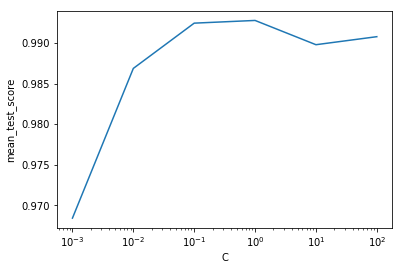

In [44]:
plt.plot(result_svm['param_linearsvc__C'],result_svm['mean_test_score'])
plt.xlabel('C')
plt.ylabel('mean_test_score')
plt.xscale("log")

Again, when choose C = 1, average precision is at its peak.   
Both score increase after we change the model to SVM and tuning the parameters.

### Random Forest

In [45]:
undersample_pipe = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier())
param_grid_rf = {'randomforestclassifier__max_leaf_nodes': [2,3,5,8,10,20,25,30]}
grid_rf = GridSearchCV(undersample_pipe,param_grid_rf,scoring='average_precision',cv=5)
grid_rf.fit(X_train_3,y_train_3)
result_rf = pd.DataFrame(grid_rf.cv_results_)

Text(0, 0.5, 'mean_test_score')

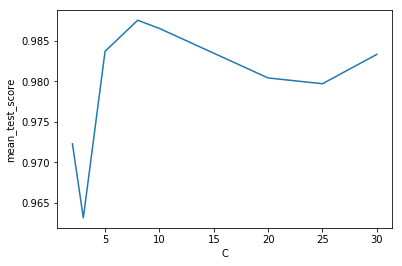

In [46]:
plt.plot(result_rf['param_randomforestclassifier__max_leaf_nodes'],result_rf['mean_test_score'])
plt.xlabel('C')
plt.ylabel('mean_test_score')

### Conclusion

After the above reasoning and modeling, we then set the best model for this task to be LinearSVM with C = 1.   
The parameter is tuning from grid search.   
We manage to improve the result(i.e. average precision) from 0.989 to over 0.992. 

## Task 5 Feature Selections

### feature importance from SVM

In [47]:
after_one_hot_features = preprocess.named_transformers_['onehotencoder'].get_feature_names()
total_features = continous_features + list(after_one_hot_features) + target_categorical
len(total_features)

50

In [48]:
svm_coef = grid_svm.best_estimator_.named_steps['linearsvc'].coef_[0]
len(svm_coef)

50

Text(0.5, 1.0, 'Linear SVM')

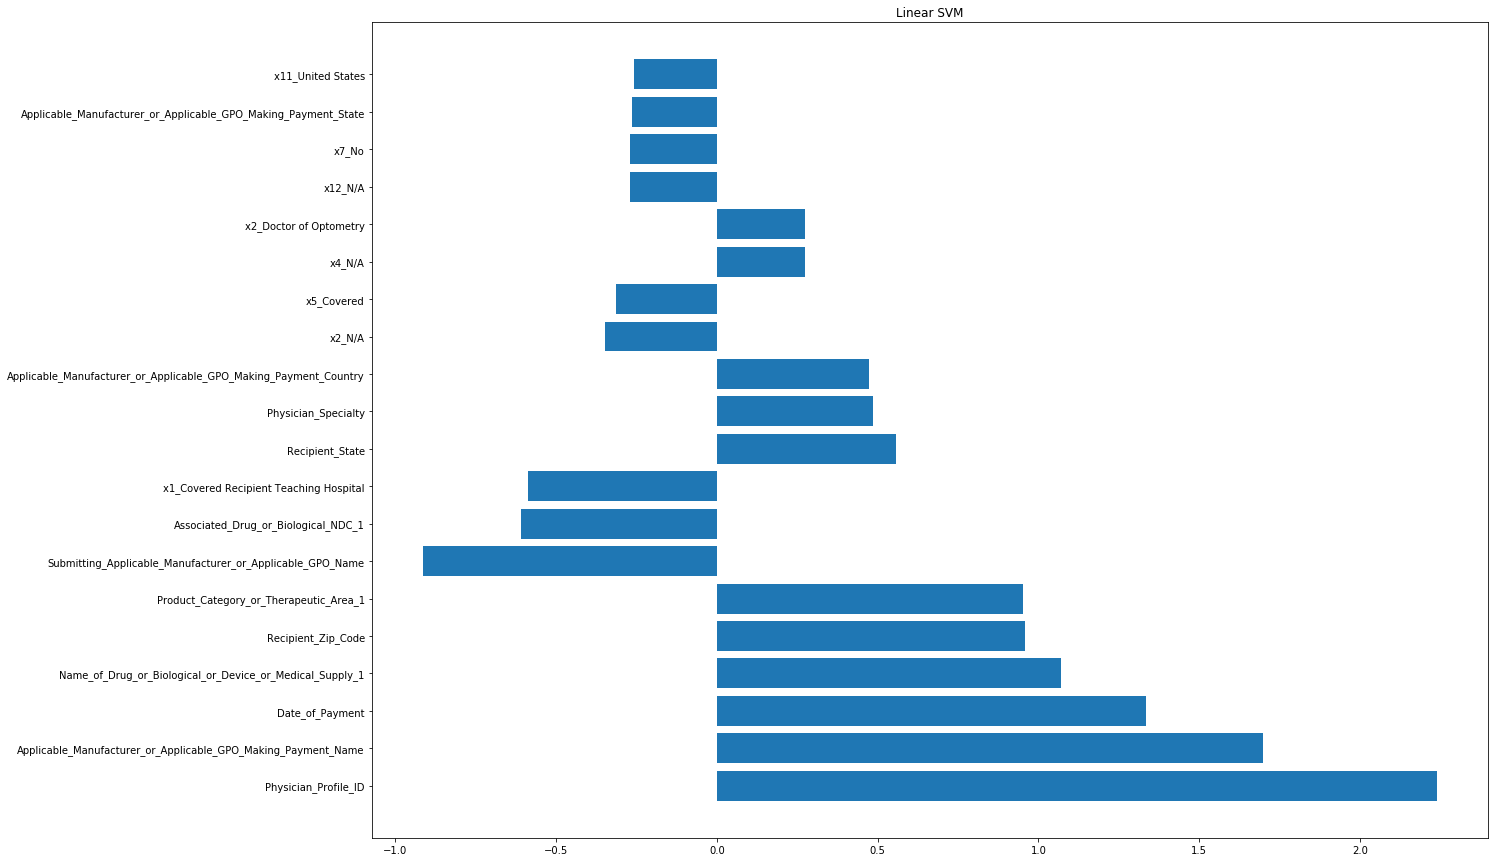

In [49]:
svm_coef_top = sorted(zip(total_features,svm_coef),key=lambda tup: abs(tup[1]))[::-1][:20]
svm_feature_name = list(zip(*svm_coef_top))[0]
svm_feature_value= list(zip(*svm_coef_top))[1]
x_pos = np.arange(len(svm_coef_top)) 
plt.figure(figsize = (20,15))
plt.barh(svm_feature_name, svm_feature_value,align='center')
# plt.xticks(x_pos, svm_feature_name) 
# plt.ylabel('Coef')
plt.title("Linear SVM")

### Partial dependence plot

In [50]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble import GradientBoostingClassifier

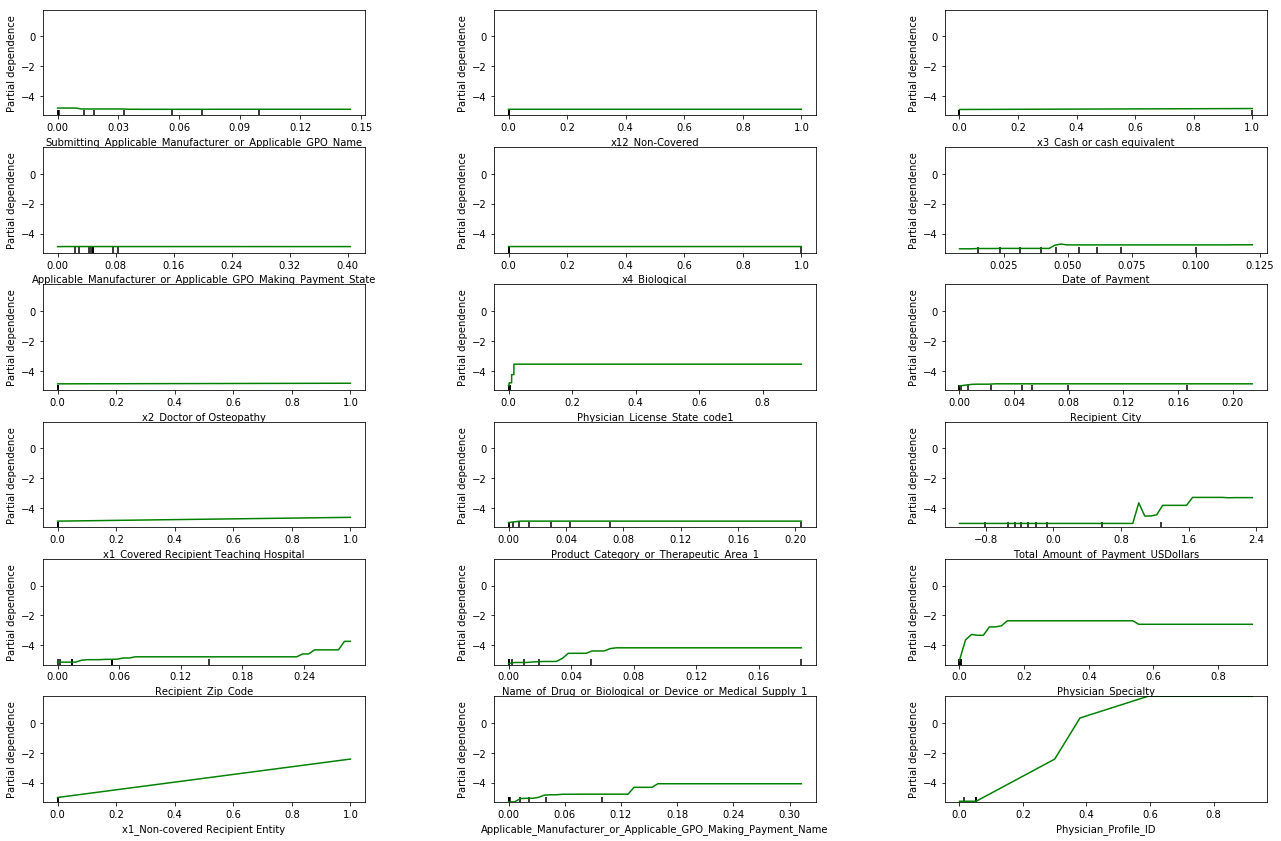

In [51]:
gbrt = GradientBoostingClassifier().fit(X_train_3, y_train_3)
fig, axs = plot_partial_dependence(
    gbrt, X_train_3, np.argsort(gbrt.feature_importances_)[-18:],
    feature_names=total_features, n_jobs=4,
    grid_resolution=50,figsize=(20,20))

As we can see from this graph, x2_Non-covered Recipient Entity, Recipient Zip Code, Physician Speciality, Total Amount of Payment USDollars, Physician_profile_id, Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country, Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1 have significant influence on our target variable

#### check each feature importance or coefficient in linear_svm, logistic regression and random forest, and plot the coefficient value or importance score

In [52]:
svm_coef = grid_svm.best_estimator_.named_steps['linearsvc'].coef_

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegression())
param_grid_logit = {'logisticregression__C': np.logspace(-3, 2, 6)}
grid_logit = GridSearchCV(undersample_pipe,param_grid_logit,scoring='average_precision',cv=5)
grid_logit.fit(X_train_3,y_train_3)

logit_coef=grid_logit.best_estimator_.named_steps['logisticregression'].coef_

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier())
param_grid_rf = {"randomforestclassifier__max_depth": [1,3,5],
              "randomforestclassifier__max_features": [2, 5, 10],}

grid_rf = GridSearchCV(undersample_pipe,param_grid_rf,scoring='average_precision',cv=5)
grid_rf.fit(X_train_3,y_train_3)

rf_coef=grid_rf.best_estimator_.named_steps['randomforestclassifier'].feature_importances_

compare the coefs in one plot with scaling

Text(0.5, 1.0, 'Random Forest &logit & Linear SVC feature importance')

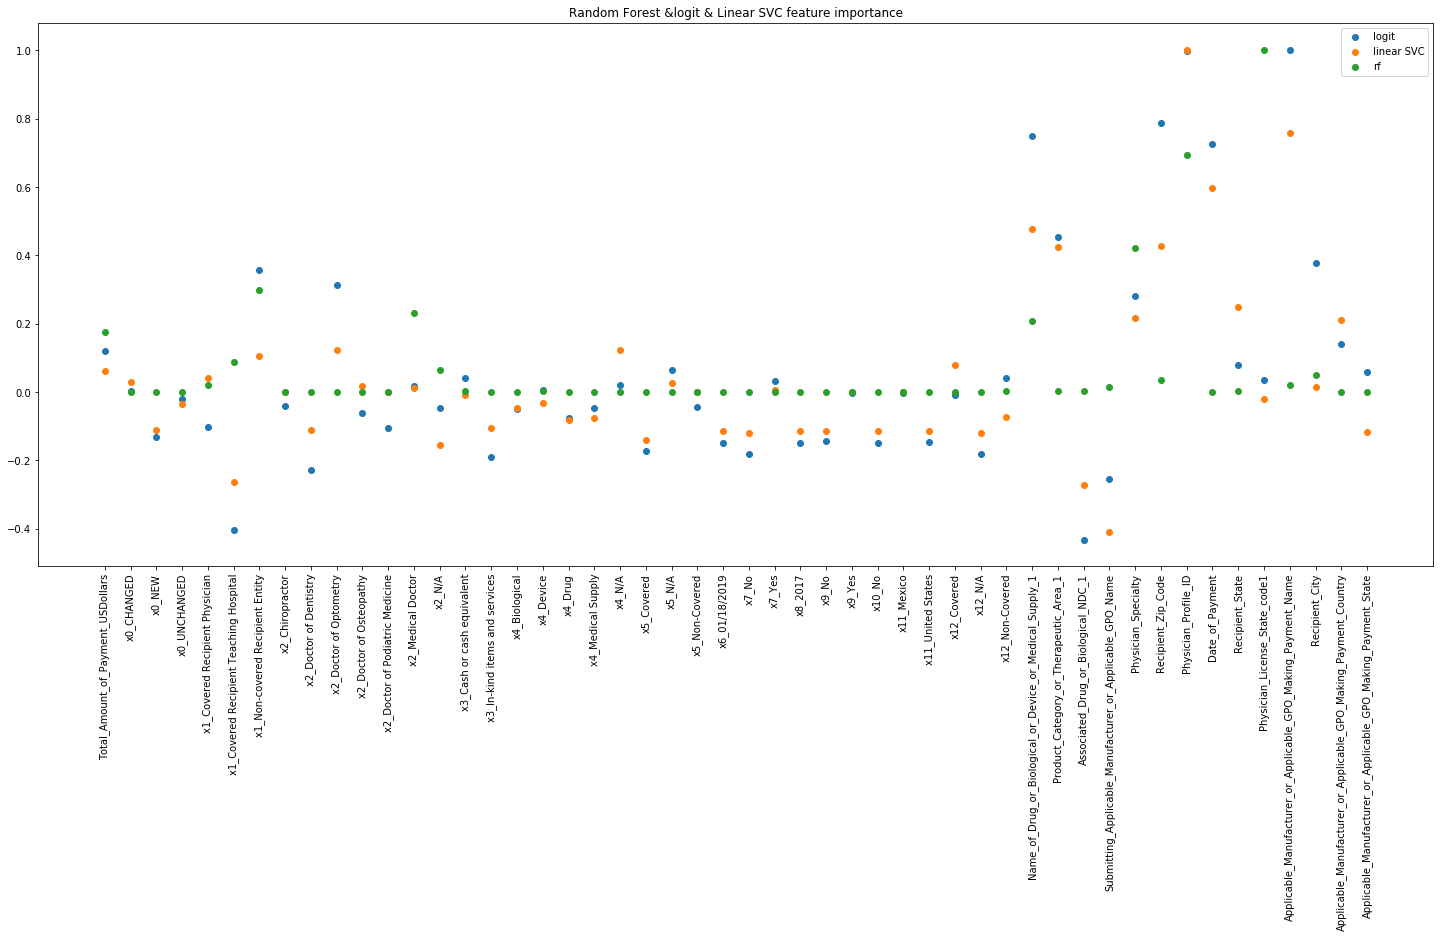

In [53]:
fig = plt.figure(figsize=(25,10))
plt.xticks(rotation=90)
plt.scatter(total_features,logit_coef[0]/max(abs(logit_coef[0])),label='logit')
plt.scatter(total_features,svm_coef[0]/max(abs(svm_coef[0])),label='linear SVC')
plt.scatter(total_features,rf_coef/max(abs(rf_coef)),label='rf')

plt.legend()
plt.title('Random Forest &logit & Linear SVC feature importance')

In [54]:
def get_topK(coef,K):
    if len(coef)!=1:
         return np.take(total_features,np.argsort(abs(coef))[::-1][:K])
    return np.take(total_features,np.argsort(abs(coef[0]))[::-1][:K])

#### Get top 15 features from each model

In [55]:
logit_top=get_topK(logit_coef,15)
print(logit_top)
svm_top=get_topK(svm_coef,15)
print(svm_top)
rf_top=get_topK(rf_coef,15)
print(rf_top)

['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name'
 'Physician_Profile_ID' 'Recipient_Zip_Code'
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'
 'Date_of_Payment' 'Product_Category_or_Therapeutic_Area_1'
 'Associated_Drug_or_Biological_NDC_1'
 'x1_Covered Recipient Teaching Hospital' 'Recipient_City'
 'x1_Non-covered Recipient Entity' 'x2_Doctor of Optometry'
 'Physician_Specialty'
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'
 'x2_Doctor of Dentistry' 'x3_In-kind items and services']
['Physician_Profile_ID'
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name'
 'Date_of_Payment'
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'
 'Recipient_Zip_Code' 'Product_Category_or_Therapeutic_Area_1'
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'
 'Associated_Drug_or_Biological_NDC_1'
 'x1_Covered Recipient Teaching Hospital' 'Recipient_State'
 'Physician_Specialty'
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Paym

#### Take their intersection

In [56]:
set(logit_top).intersection(set(svm_top)).intersection(set(rf_top))

{'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Physician_Profile_ID',
 'Physician_Specialty',
 'Product_Category_or_Therapeutic_Area_1',
 'Recipient_Zip_Code',
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
 'x1_Covered Recipient Teaching Hospital'}

#### Taking the partial plot into consideration, we remove one feature which is Product_Category_or_Therapeutic_Area_1
#### In the end, we think these 5 features are significant 

In [57]:
{'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Physician_Profile_ID',
 'Recipient_City',
 'Recipient_Zip_Code'}

{'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Physician_Profile_ID',
 'Recipient_City',
 'Recipient_Zip_Code'}

#### In Task4, our best model is linear SVC, the top 15 most important features accourding to our graph are

['Physician_Profile_ID'
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name'
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'
 'Date_of_Payment' 'Recipient_Zip_Code'
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State'
 'Product_Category_or_Therapeutic_Area_1'
 'x2_Covered Recipient Teaching Hospital'
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'
 'x2_Non-covered Recipient Entity' 'Recipient_City'
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country'
 'x10_Non-Covered' 'x9_Doctor of Optometry' 'x9_Doctor of Dentistry']

#### But if we only select the 5 features we consider significant, we will get the following results

In [58]:
undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LinearSVC())
param_grid_svm = {'linearsvc__C': np.logspace(-5, 0, 6)}
grid_svm = GridSearchCV(undersample_pipe,param_grid_svm,scoring='average_precision',cv=5)

In [59]:
best5=['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Physician_Profile_ID',
 'Recipient_City',
 'Recipient_Zip_Code']
idx_ls=[]
for f in best5:
    idx_ls.append(total_features.index(f))
idx_ls

[46, 36, 42, 47, 41]

In [60]:
grid_svm.fit(X_train_3[:,idx_ls],y_train_3)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('randomundersampler', RandomUnderSampler(random_state=None, ratio=None, replacement=False,
          return_indices=False, sampling_strategy='auto')), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'linearsvc__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=0)

In [61]:
result_svm = pd.DataFrame(grid_svm.cv_results_)

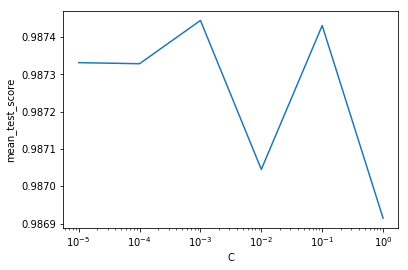

In [62]:
plt.plot(result_svm['param_linearsvc__C'],result_svm['mean_test_score'])
plt.xlabel('C')
plt.ylabel('mean_test_score')
plt.xscale("log")

### Conclusion

As we can see from this graph, only keeping 5 features does not affect our best model performance. So, we can conclude, these 5 features are significant and sufficent.

## Task 6 An explainable model

#### Since a decision tree with small number of leafs is very explainable, we choose a decision tree classifier with small number of leafs as our explainable model.

In [63]:
X_task6 = X_train_3[:,idx_ls]

In [64]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [65]:
undersample_pipe = make_imb_pipeline(RandomUnderSampler(), DecisionTreeClassifier())
param_grid_dt = {"decisiontreeclassifier__max_leaf_nodes": [2,3,5,7,10]}

grid_dt = GridSearchCV(undersample_pipe,param_grid_dt,scoring='average_precision',cv=5)
grid_dt.fit(X_task6,y_train_3)
result_dt = pd.DataFrame(grid_dt.cv_results_)

Text(0, 0.5, 'mean_test_score')

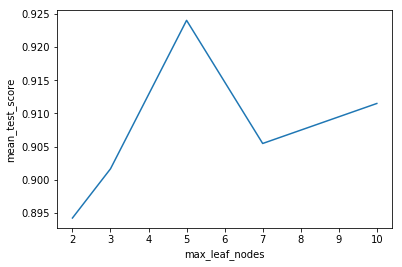

In [66]:
plt.plot(result_dt['param_decisiontreeclassifier__max_leaf_nodes'],result_dt['mean_test_score'])
plt.xlabel('max_leaf_nodes')
plt.ylabel('mean_test_score')

In [67]:
tree = DecisionTreeClassifier(max_leaf_nodes=5)
tree.fit(X_task6,y_train_3)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=5, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [68]:
from sklearn.externals.six import StringIO  
from IPython.display import Image 
import pydotplus

In [69]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

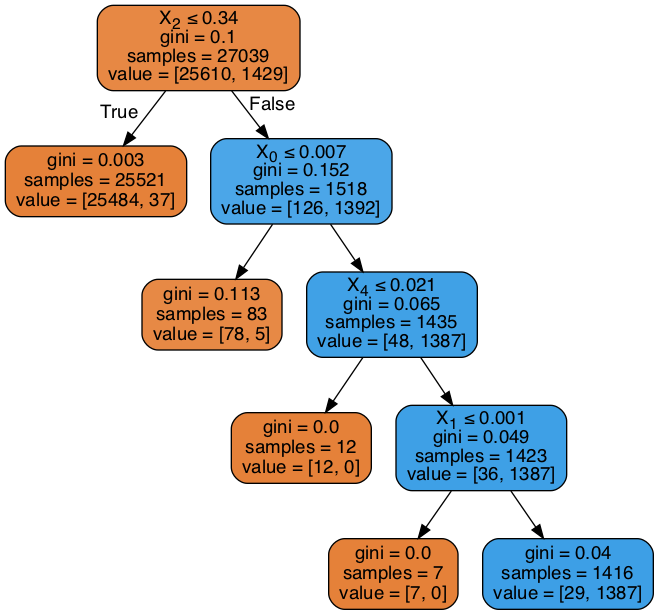

In [70]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Conclusion

We have created a decision tree classfier with only 5 feature we selected from Task 5.   
They are:  

* 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name'
* 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'
* 'Physician_Profile_ID'
* 'Recipient_City'
* 'Recipient_Zip_Code'

As we can see from the above result, with max_leaf_nodes = 5, we still get get average_precision score around 0.93.  
And after we target encoding the above 5 features, we can see that if we know the Physician_Profile_ID (i.e $X_2$), and Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name (i.e. $X_0$), we can basically what kind of payment it is.